In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas 
from glob import glob
from scipy import stats
from sklearn.preprocessing import StandardScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Perform PheWAS
This analysis was born out of a dissatisfaction with gene ontology analysis as a means of gaining biological insight into a set of genes. Here, we instead survey genes associated with our molecular gradients for somewhat direct phenotypes. We do this by finding SNPs that are associated with expression of the genes in question, and finding phenotypes that are genomewide significantly related to those SNPs. In doing so, we find SNPs that affect gene expression and are also associated with a phenotype. This is still not causation, but it is a much more direct link the GO analysis

In [2]:
figdir = './figures/'

#### Load data

The following data represent SNPs associated with "top genes" in each component in the PSYCHEncode dataset, and phenotypes associated with those SNPs. See Methods section of manuscript for detailson how these tables were created.

In [4]:
cdf_pths = sorted(glob('data/PLS_eQTLs_PEC_GWAScat_C*.csv'))
cdf_pths

['data/PLS_eQTLs_PEC_GWAScat_C1.csv',
 'data/PLS_eQTLs_PEC_GWAScat_C2.csv',
 'data/PLS_eQTLs_PEC_GWAScat_C3.csv']

This data represents SNPs associated with "top genes" in GTEx. We will only keep associations that are present in both datasets

In [6]:
gtex = pandas.read_csv('data/egenes_GTEx_PEC_intersect.txt',
                      header=None)[0]

In [7]:
# This was created in NB3: PLS_ModelExploration
comps = pandas.read_csv('data/all_comps.csv')
comps.head()

,Unnamed: 0,C1,gene_symbol,gene_name,C2,C3,C1_genelist,C2_genelist,C3_genelist
0,0,0.001956,A1BG,alpha-1-B glycoprotein,0.003711,-0.021865,0.0,0.0,1.0
1,1,-0.007211,A1BG-AS1,NaN,-0.007837,-0.003920,0.0,0.0,0.0
2,2,0.005342,A2M,alpha-2-macroglobulin,0.008298,0.001742,0.0,0.0,0.0
3,3,-0.007153,A2ML1,alpha-2-macroglobulin-like 1,-0.004419,-0.006947,0.0,0.0,0.0
4,4,-0.002024,A3GALT2,NaN,0.001295,0.002109,0.0,0.0,0.0


In [8]:
gene_map = pandas.read_csv('data/ENSG_mapp.tsv',sep='\t',header=None)
gene_map.columns = ['ensg','gene_symbol']
gene_map.head()

,ensg,gene_symbol
0,ENSG00000260633,AC010207.1
1,ENSG00000144746,ARL6IP5
2,ENSG00000170837,GPR27
3,ENSG00000264920,AC018521.5
4,ENSG00000263603,AC127024.2


#### Subset data to only significant hits

In [9]:
# First, we need to gather our "gene sets" -- groups of "significant" genes.
# We'll take the top 0.8%. That's an alpha of 0.05 divided by 3 for 3 componets
# and divided in half for two-tailed approach.
sig_genes = []
perc = 0.025 / 3
for i in range(1,4):
    cvec = comps.sort_values('C%s'%i,ascending=True).gene_symbol.tolist()
    thresh = int(round(len(cvec) * perc))
    sig_genes += cvec[-thresh:]
    sig_genes += cvec[:thresh]

In [10]:
# Find the number of "significant" genes that have eQTLs with genomewide-signficant genes
len(set(gene_map.gene_symbol) & set(sig_genes))

29

#### Build spreadsheet with PheWAS information

In [11]:
# the spreadsheets linking gene to snp to phenotype are formatted a bit strangely.
# this code will create a spreadsheet indexed by phenotype, and will add a "hit"
# every time a SNP that is a significant eQTL of a component-relevant gene (i.e. 
# significantly contributing to molecular gradient) is genomewide-significantly 
# related to a phenotype. 

jnk = pandas.read_csv(cdf_pths[0])

alleqtls = [] # container
# get all phenotype hits
for q,cdf_pth in enumerate(cdf_pths):
    cdf = pandas.read_csv(cdf_pth) # load spreadsheet
    cdf = cdf[cdf.gene.isin(gtex)] # reduce to only SNPS linked to significant genes
    print('%s eQTLs found for C%s'%(len(cdf),(q+1))) # print # of SNPs
    alleqtls += cdf.X1.tolist() # keep track of # of SNPs
    
    # initialize dataframe
    c = cdf_pth.split('_')[-1].split('.')[0] # get component
    startcol = 3 # starting from column 3...
    # if first run, build dataframe
    if c == 'C1':
        allhits = pandas.DataFrame(cdf.X2.value_counts())
        allhits.columns = [c]
        startcol = 4
    # else build columns
    if c not in allhits.columns:
        allhits.loc[:,c] = np.zeros(len(allhits))
    # go through each colum and extract phenotypes
    for col in cdf.columns[startcol:]:
        vcs = cdf[col].value_counts() # grab non-null values
        for i,val in vcs.iteritems(): # iterate through them
            # store phenotype hits additively
            if i in allhits.index:
                allhits.loc[i,c] += val
            else:
                allhits.loc[i,c] = val
allhits = allhits.fillna(value=0)


1616 eQTLs found for C1
1644 eQTLs found for C2
2547 eQTLs found for C3


In [12]:
# How many eQTLS altogether?
len(np.unique(alleqtls))

5066

In [13]:
# have a look at an example
allhits.sort_values('C1',ascending=False).head(10)

,C1,C2,C3
Feeling guilty,3.0,0.0,0.0
Neuroticism,3.0,0.0,0.0
Experiencing mood swings,2.0,0.0,0.0
Feeling miserable,2.0,0.0,0.0
Bipolar disorder,2.0,0.0,3.0
Irritable mood,2.0,0.0,0.0
Schizophrenia,2.0,0.0,0.0
C-reactive protein levels,1.0,0.0,0.0
White matter microstructure (radial diusivities),1.0,0.0,0.0
Feeling hurt,1.0,0.0,0.0


In [14]:
# Now we will go back through the spreadsheets and add a column indicating the genes
# that associated with the SNPs associated with the pneotypes. Again, the code here
# is weird because it deals with the odd structure of the spreadsheet. It will create
# a list of genes within the gene column.
for cdf_pth in cdf_pths:
    cdf = pandas.read_csv(cdf_pth)
    cdf = cdf[cdf.gene.isin(gtex)]
    c = cdf_pth.split('_')[-1].split('.')[0]
    print('working on',c)
    for i,row in allhits.iterrows():
        count = 0
        genes = []
        for col in cdf.columns[3:]:
            if i in cdf[col].values:
                phedf = cdf[cdf[col]==i]
                count += len(phedf.hgnc.unique())
                genes += phedf.hgnc.unique().tolist()
        allhits.loc[i,'%s_geneHits'%c] = count
        if count != 0:
            allhits.loc[i,'%s_genes'%c] = str(genes).replace('[','').replace(']','')

working on C1
working on C2
working on C3


In [24]:
## We can save our progress if we wish, so we don't have to do all that again.
# allhits.to_csv('data/PLS_eQTLs_PEC_GWAScat_organized_GTEXInter.csv')

In [25]:
## load data if you wish
# allhits = pandas.read_csv('data/PLS_eQTLs_PEC_GWAScat_organized_GTEXInter.csv',
#                          index_col=0)

In [22]:
# for reference, here is a list of all the genes that made it through the pipeline
good_genes = ['FAM215B','MCHR1','SLC17A6','PART1','PSCA','GAL','LINC01137','DESI1','DNAH5','SLN','FREM3',
'HAPLN4','GAL','HSBP1L1','ADAMTS8','KLHL7-DT','CHCHD2','GCSHP5']

# Simplify phenotypes

Here, each phenotype has been painstakingly added to a larger subtopic, which is part of a still larger topic. This will make it easier to display information graphically, and is helpful for sorting and consolidating information.

At first pass, we had a more stringent approach and had many more hits, so there are far more phenotypes represented here than made it to the PheWAS. But I will leave them all in for future analyses.

In [16]:
keymap = {
    # traits
    'traits':{
    'basic physical traits': ['Hair color','Lobe attachment (rater-scored or self-reported)',
                             'Primary tooth development (number of teeth)',
                              'Primary tooth development (time to first tooth eruption)',
                             'Heel bone mineral density',
                              'Pediatric bone mineral content (radius)',
                             'Total body bone mineral density',],
    'Anthropometric traits': ['Anthropometric traits','Body fat distribution (leg fat ratio)',
                              'Body fat distribution (trunk fat ratio)',
                              'Body mass index (age>50)',
                              'Body mass index x sex x age interaction (4df test)',
                             'Weight','Height','Obesity-related traits',
                             'Body mass index','Body size at age 10',
                             'Waist-hip ratio','Waist-to-hip ratio adjusted for BMI',],
    'sleep': ['Chronotype','Morning vs. evening chronotype','Sleep duration',],
    'eye traits and functions': ['macular thickness',
                                'Exploratory eye movement dysfunction in schizophrenia (cognitive search score)',
                                'Intraocular pressure','Refractive error',]},
    
    # random
    'other': {
    'metabolite levels': ['Metabolite levels','Metabolic traits',
                          'Urinary metabolite levels in chronic kidney disease',
                          'Blood metabolite levels','Blood urea nitrogen levels',
                          'Estimated glomerular filtration rate',
                          'Fractional excretion of metabolites in chronic kidney disease',
                          'Serum 25-Hydroxyvitamin D levels',
                          'Serum alkaline phosphatase levels',
                          'Serum metabolite concentrations in chronic kidney disease',
                          'Serum metabolite levels',
                          'Serum uric acid levels','Triglycerides',
                         ],
    'endocrinological': ['Sex hormone-binding globulin levels adjusted for BMI',
                        'Age at menopause','Bioavailable testosterone levels',
                        'Sex hormone-binding globulin levels',
                         'Serum thyroid-stimulating hormone levels',],
    'dermatological': ['Alopecia areata','Psoriasis vulgaris', 'Vitiligo',],
    'hematology': ['Hematology traits','Hemoglobin concentration',
                  'High light scatter reticulocyte count','Mean corpuscular hemoglobin',
                   'High light scatter reticulocyte percentage of red cells',
                  'Mean spheric corpuscular volume','Plateletcrit','Blood protein levels',
                  'Hematocrit','Hemoglobin','Mean corpuscular volume','Mean platelet volume',
                   'Monocyte count','Monocyte percentage of white cells',
                  'Platelet count','Platelet distribution width',
                  'Red blood cell count','Red cell distribution width',],
    'cholesterol': ['LDL cholesterol levels','LDL cholesterol levels in current drinkers',
                    'LDL cholesterol levels x alcohol consumption (drinkers vs non-drinkers) interaction (2df)',
                    'LDL cholesterol levels x alcohol consumption (regular vs non-regular drinkers) interaction (2df)',
                    'LDL cholesterol x physical activity interaction (2df test)',
                   'Low density lipoprotein cholesterol levels','Total cholesterol levels',
                   ]},
    
    # nervous system traits
    'nervous system': {
    'brain size': ['Brain region volumes','Brain volume in infants (grey matter)',
                  'Cortical surface area','Subcortical volume (MOSTest)',],
     'neuroimmune': ['Chemerin levels',],
    'white matter': ['White matter microstructure (radial diusivities)',
                    'White matter microstructure (fractional anisotropy)'],
    'cognition / intel': ['Cognitive performance (processing speed)',
                          'General cognitive ability','Intelligence',
                         'Reaction time','Self-reported math ability (MTAG)',],
    'education': ['Educational attainment (MTAG)','Highest math class taken (MTAG)',
                  'Educational attainment (years of education)',],
    'neurovascular': ['Headache','Migraine',]},
    
    # NDD
    'NDD':{
    'AD': ["Alzheimer's disease (cognitive decline)",
           'Cerebrospinal fluid biomarker levels','Diffuse plaques (SNP x SNP interaction)',
           'Neurofibrillary tangles (SNP x SNP interaction)',
           "Rate of cognitive decline in Alzheimer's disease",
           'Total PHF-tau (SNP x SNP interaction)',
          ],
    'Other NDD': ['Multiple sclerosis','Amyotrophic lateral sclerosis'],
    'PD': ["Parkinson's disease",
           "Parkinson's disease or first degree relation to individual with Parkinson's disease",
          ]},
   
    
    # Psychiatr
    'psychiatric':{
    'Drug Abuse': ['Age of smoking initiation (MTAG)','Alcohol consumption (drinks per week)',
                  'Alcohol consumption (drinks per week)','Alcoholic chronic pancreatitis',
                  'Coffee consumption','Illicit drug use','Maximum habitual alcohol consumption',
                  'Smoking initiation (ever regular vs never regular)',
                   'Smoking initiation (ever regular vs never regular)',
                  'Smoking initiation (ever regular vs never regular) (MTAG)',],
    'Mood disorders': ['Bipolar I disorder','Bipolar disorder','Depression',
                       'Depression (broad)','Feeling guilty','Feeling worry',
                      'Major depressive disorder in trauma exposed individuals',
                      'Neurociticism','Neuroticism',],
    'Psychosis': ['Schizophrenia','Suicide attempts in bipolar disorder or schizophrenia',]},
    
    # other disease
    'other disease':{
    'heart disease or function': ['Coronary artery disease','Coronary artery disease',
                     'Atrial fibrillation',
                      'Electrocardiogram morphology (amplitude at temporal datapoints)',
                     'Global electrical heterogeneity phenotypes','PR interval',
                     'Postoperative atrial fibrillation after cardiac surgery',
                     'Pulse pressure','Severe aortic features in Marfan syndrome',
                                  'Cardiovascular disease',
                                 'Diastolic blood pressure',
                                 'Systolic blood pressure',],
    'cancer': ['Basal cell carcinoma','High-grade serous ovarian cancer',
              'Breast cancer','Core binding factor acute myeloid leukemia',
               'Toxicity response to radiotherapy in prostate cancer (hematuria) (time to event)',
              ],
    'immune': ['CTACK levels','C-reactive protein levels',
               'Lymphocyte percentage of white cells','Sarcoidosis','Lymphocyte counts',
               'Neutrophil count','White blood cell count',],
        'bowel disease': ["Chronic inflammatory diseases (ankylosing spondylitis, Crohn's disease, psoriasis, primary sclerosing cholangitis, ulcerative colitis) (pleiotropy)",
                         'Classic bladder exstrophy','Inflammatory bowel disease',
                         "Crohn's disease",'Ulcerative colitis',],
    'non-brain disease': ['Gynecologic disease',  
                         'Non-alcoholic fatty liver disease activity score in non-alcoholic fatty liver disease',
                         'Osteoarthritis','Primary biliary cirrhosis','Shingles',
                         'Systemic lupus erythematosus',],
    'genetic disorder': ['High chromosomal aberration frequency (chromosome type)',
                        'Protein quantitative trait loci (liver)',],
    'diabetes': ['Microalbuminuria in type 1 diabetes','Type 2 diabetes',],
    'pulmonary': ['Lung function (FEV1/FVC)','Post bronchodilator FEV1',
                  'Post bronchodilator FEV1/FVC ratio',
                  'Post bronchodilator FEV1/FVC ratio in COPD',
                  'Chronic obstructive pulmonary disease',
                'Chronic obstructive pulmonary disease or high blood pressure (pleiotropy)',
                 'Lung function (FVC)'],
    'developmental disorder': ['Spontaneous preterm birth with premature rupture of membranes',]},
        
}



In [17]:
round2 = {'Drug Abuse': ['3-hydroxypropylmercapturic acid levels in smokers',
                        'Alcohol consumption (drinks per week) (MTAG)',
                         'Alcohol use disorder (consumption score)',
                        'Bitter alcoholic beverage consumption',
                        'Caffeine consumption from coffee or tea',
                        'Cannabis dependence symptom count','Lifetime smoking index',
                        'Opioid sensitivity','Problematic alcohol use (MTAG)',
                        'Smoking cessation', 'Smoking cessation (MTAG)',
                         'Smoking initiation','Smoking status',],
          'cognition / intel': ['Abstraction and mental flexibility',
                                 'Cognitive flexibility','Cognitive performance',
                                 'Cognitive performance (MTAG)', 'Intelligence (MTAG)',
                               'Language performance in older adults (adjusted for episodic memory)',
                               'Reading or mathematical ability','Self-reported math ability',],
          'diabetes': ['Acute insulin response','Peak insulin response','Type 1 diabetes',],
          'Anthropometric traits': ['Adult body size','Appendicular lean mass',
                                   'BMI (adjusted for smoking behaviour)',
                                    'BMI in non-smokers',
                                   'Body mass index (joint analysis main effects and smoking interaction)',
                                   'Fat-free mass','Hip circumference adjusted for BMI',
                                   'Physical activity (walking duration)',
                                   'Predicted visceral adipose tissue',
                                   'Waist circumference adjusted for body mass index',
                                     'Waist-to-hip ratio adjusted for BMI (age <50)',
                                     'Waist-to-hip ratio adjusted for BMI (joint analysis for main effect and physical activity interaction)',
                                     'Waist-to-hip ratio adjusted for BMI in active individuals',
                                     'Waist-to-hip ratio adjusted for BMI x sex x age interaction (4df test)',
                                     'Waist-to-hip ratio adjusted for body mass index',],
          'pulmonary': ['Adult onset asthma and/or BMI', 
                        'Allergic disease (asthma, hay fever or eczema)',
                       'Asthma','Asthma (adult onset)','Asthma (age of onset)',
                        'Asthma (childhood onset)','Atopic asthma','FEV1',
                       'Lung function (FEV1)','Nonatopic asthma',
                         'Nonatopic asthma and/or BMI','Peak expiratory flow',
                       'Response to bronchodilator in chronic obstructive pulmonary disease (change in FEV1)',],
          'endocrinological':['Age at voice drop','Biological sex',
                             'Male puberty timing (age at voice breaking MTAG)',
                             'Male puberty timing (early vs. average onset facial hair)',
                             'Male puberty timing (early vs. average onset voice breaking)',
                             'Male puberty timing (late vs. average onset facial hair)',
                             'Male puberty timing (late vs. average onset voice breaking)',
                             'Male-pattern baldness','Menarche (age at onset)',
                             'Menopause (age at onset)','Puberty onset (breast development)',
                             'Total testosterone levels',],
          'non-brain disease': ['Age-related hearing impairment (MTAG)',
                               'Aspartate aminotransferase levels',
                               'Carpal tunnel syndrome','Disc degeneration (lumbar)',
                                'Haemorrhoidal disease','Hypothyroidism',
                               'Intrinsic epigenetic age acceleration',
                               'Itch intensity from mosquito bite adjusted by bite size',
                               'Medication use (thyroid preparations)',
                               'Mononucleosis','Parental lifespan','Periodontitis (CDC/AAP)',
                               'Renal function-related traits (BUN)',
                               'Thyroid stimulating hormone levels',
                               'Tonsillectomy','Urate levels',
                             'Urinary tract infection frequency',],
          'AD': ["Alzheimer's disease in APOE e4- carriers",
                 'Brain amyloid deposition (PET imaging)',],
          'diet': ['Oily fish consumption','Bitter beverage consumption',
                    'Bitter non-alcoholic beverage consumption',
                   'Fish- and plant-related diet','Lamb consumption','Meat-related diet',
                  'Pork consumption','Tea consumption',],
          'basic physical traits': ['Ankle injury',
                                   'Bone mineral density (paediatric, skull)',
                                   'Facial morphology (factor 17, height of vermillion upper lip)',
                                 'Facial morphology (factor 19)',
                                 'Fractures','Hand grip strength',
                                    'Heel bone mineral density (MTAG)',
                                   'Leukocyte telomere length',
                                   'Low tan response','Total body bone mineral density (MTAG)',
                                   'Youthful appearance (self-reported)'],
          'Mood disorders': ['Anorexia nervosa, attention-deficit/hyperactivity disorder, autism spectrum disorder, bipolar disorder, major depression, obsessive-compulsive disorder, schizophrenia, or Tourette syndrome (pleiotropy)',
                            'Attention deficit hyperactivity disorder',
                             'Attention deficit hyperactivity disorder symptom score',
                            'Bipolar II disorder','Bipolar disorder (MTAG)',
                             'Bipolar disorder or major depressive disorder',
                             'Bipolar disorder vs major depressive disorder (ordinary least squares (OLS))',
                            'Depressive symptoms','Experiencing mood swings',
                            'Fear of severe pain',
                             'Feeling fed-up','Feeling hurt','Feeling miserable',
                             'Feeling nervous','Feeling tense','General factor of neuroticism',
                             'General risk tolerance (MTAG)','Irritable mood',
                             'Life satisfaction','Major depressive disorder',
                             'Major depressive disorder in trauma-unexposed individuals',
                             'Major depressive disorder vs ADHD (ordinary least squares (OLS))',
                            'Positive affect','Adventurousness',
                            'Response to cognitive-behavioural therapy in anxiety disorder',
                            'Sensitivity to environmental stress and adversity',
                            'Tourette syndrome', 'Worry',
                             "Tourette's syndrome or obsessive-compulsive disorder",],
          'cholesterol': ['Apolipoprotein A-IV levels','Apolipoprotein A1 levels',
                          'Apolipoprotein B levels','HDL cholesterol',
                          'HDL cholesterol levels','HDL cholesterol levels in HIV infection',
                          'HDL cholesterol levels in current drinkers',
                          'HDL cholesterol levels x alcohol consumption (drinkers vs non-drinkers) interaction (2df)',
                          'HDL cholesterol levels x alcohol consumption (regular vs non-regular drinkers) interaction (2df)',
                          'HDL cholesterol levels x short total sleep time interaction (2df test)',
                          'LDL cholesterol levels x long total sleep time interaction (2df test)',
                         'High density lipoprotein cholesterol levels',
                         'Lipoprotein phospholipase A2 activity in cardiovascular disease',
                         'Medication use (HMG CoA reductase inhibitors)',],
          'heart disease or function': ['Arrhythmia','Blood protein levels in cardiovascular risk',
                                       'Calcific aortic valve stenosis',
                                        'Chronic venous disease','Homocysteine levels',
                                       'Medication use (agents acting on the renin-angiotensin system)',
                                       'PR interval in Tripanosoma cruzi seropositivity',
                                       'PR segment duration',
                                        'Preeclampsia (maternal genotype effect)',
                                       'Response to beta blocker use in hypertension (systolic blood pressure)',
                                        'Sudden cardiac arrest',],
          'immune': ['Autoimmune traits','Basophil count',
                     'Basophil percentage of white cells',
                    'CD6 levels','High IL-1beta levels in gingival crevicular fluid',
                    'IgG glycosylation','Interleukin-18 levels',
                     'Monokine induced by gamma interferon levels',
                    'Neonatal cytokine/chemokine levels (fetal genetic effect)',
                    'Neutrophil percentage of granulocytes',
                 'Neutrophil percentage of white cells',
                    'Response to abacavir-containing treatment in HIV-1 infection (virologic failure)',
                    'Response to efavirenz-containing treatment in HIV 1 infection (virologic failure)',
                    'Tenofovir clearance in HIV infection',],
          'cancer': ['BRCA1/2-negative high-risk breast cancer',
                     'Beta-2 microglubulin plasma levels',
                    'Bladder cancer','Breast cancer specific mortality in breast cancer',
                     'Breast cancer, ovarian cancer or prostate cancer (pleiotropy)',
                    'Cancer (pleiotropy)','Cervical cancer','Colorectal cancer',
                    'Cutaneous malignant melanoma','Cutaneous squamous cell carcinoma',
                    'E-selectin levels','Gastric cancer',
                     'First fracture in long-term childhood cancer survivors (time to event)',
                    'Gastric cancer','Keratinocyte cancer (MTAG)','Myeloid white cell count',
                    'Myeloperoxidase levels','Nevus count or cutaneous melanoma',
                    'Non-melanoma skin cancer','Oropharynx cancer','Prostate cancer',],
          'brain size': ['Brain morphology (MOSTest)','Cephalic index',
                        'Cortical surface area (MOSTest)',
                         'Cortical surface area (global PC1)',
                         'Cortical surface area (min-P)',
                        'Intracranial volume','Superior temporal gyrus volume',
                        'Third ventricle volume',],
          'eye traits and functions': ['Central corneal thickness',
                                       'Glaucoma (primary open-angle)',
                                      'Initial pursuit acceleration',
                                      'Keratoconus','Macular thickness',
                                      'Optic disc size',
                                      'Retinal nerve fibre layer (RNFL) thickness',
                                     'Retinal nerve fibre layer thickness or ganglion cell inner plexiform layer thickness (MTAG)',
                                      'Spherical equivalent or myopia (age of diagnosis)',
                                      'Vertical cup-disc ratio',],
          'education': ['Cognitive aspects of educational attainment',
                       'Highest math class taken','Household income',
                         'Household income (MTAG)',],
         'sleep':['Daytime nap','Ease of getting up in the morning','Insomnia',
                 'Morning person','Morningness','Narcolepsy',],
         'bowel disease':['Diverticular disease',
                          'Gut microbiota (bacterial taxa, rank normal transformation method)',
                         'Gut microbiota presence (family Bacteroidales S24 7group id.11173)',
                         'Peptic ulcer disease',],
         'dermatological': ['Eczema','Hay fever and/or eczema',],
          'hematology': ['Eosinophil counts','Eosinophil percentage of white cells',
                        'Granulocyte count','Granulocyte percentage of myeloid white cells',
                        'Hemoglobin levels','Immature fraction of reticulocytes',
                        'Mean corpuscular hemoglobin concentration',
                         'Mean reticulocyte volume','Non-albumin protein levels',
                        'Reticulocyte count','Reticulocyte fraction of red cells',
                        'Sum eosinophil basophil counts',
                         'Sum neutrophil eosinophil counts',],
          'metabolite levels': ['Fasting blood glucose','Glycine levels',
                               'Protein quantitative trait loci',
                               'Serum folate levels','Triglyceride levels',
                               'Triglyceride levels in current drinkers',
                                 'Triglyceride levels x alcohol consumption (drinkers vs non-drinkers) interaction (2df)',
                                 'Triglyceride levels x alcohol consumption (regular vs non-regular drinkers) interaction (2df)',
                                 'Triglyceride levels x short total sleep time interaction (2df test)',
                                 'Triglycerides x physical activity interaction (2df test)',],
          'Other NDD': ['Hippocampal sclerosis of aging',
                        'Neurological blood protein biomarker levels',],
          'neurovascular':['Intracranial aneurysm',
                           'Periventricular white matter hyperintensities',
                          'Stroke','White matter hyperintensities',],
          'Psychosis': ['Schizophrenia (MTAG)','Suicide attempts in schizophrenia',],
          'white matter': ['White matter microstructure (axial diusivities)',]
         }


In [18]:
# Do a quick search to see if I missed any phenotypes
missing = []
for topic,themes in round2.items():
    found = False
    for main,subs in keymap.items():
        if topic in subs:
            vals = keymap[main][topic]
            keymap[main].update({topic:vals + themes})
            found = True
    if not found:
        missing.append(topic)

In [19]:
# Update with the missing phenotypes
keymap['traits'].update({'diet': round2['diet']})

In [20]:
# add the topic and subtopic to the information spreadsheet
missing = []
for i,row in allhits.iterrows():
    found = False
    for main,subs in keymap.items():
        for sub,things in subs.items():
            if i in things:
                allhits.loc[i,'main'] = main
                allhits.loc[i,'subtopic'] = sub
                found = True
    if not found:
        missing.append(i)

# Plot and analyze
The primary plot chosen for the manuscript is an alluvial plot, which was made in R and not by me. However, the code below includes an inferior alternative visualization

In [48]:
allhits[['main','subtopic']+allhits.columns[:9].tolist()]

,main,subtopic,C1,C2,C3,C1_geneHits,C1_genes,C2_geneHits,C2_genes,C3_geneHits,C3_genes
Experiencing mood swings,psychiatric,Mood disorders,2.0,0.0,0.0,1.0,'FAM215B',0.0,NaN,0.0,NaN
Feeling guilty,psychiatric,Mood disorders,3.0,0.0,0.0,2.0,"'FAM215B', 'FAM215B'",0.0,NaN,0.0,NaN
Neuroticism,psychiatric,Mood disorders,3.0,0.0,0.0,2.0,"'FAM215B', 'MCHR1'",0.0,NaN,0.0,NaN
Cognitive aspects of educational attainment,nervous system,education,1.0,0.0,0.0,1.0,'FAM215B',0.0,NaN,0.0,NaN
Lung function (FVC),other disease,pulmonary,1.0,0.0,1.0,1.0,'FAM215B',0.0,NaN,1.0,'ADAMTS8'
...,...,...,...,...,...,...,...,...,...,...,...
Basophil percentage of white cells,other disease,immune,0.0,0.0,1.0,0.0,NaN,0.0,NaN,1.0,'HAPLN4'
Diastolic blood pressure,other disease,heart disease or function,0.0,0.0,1.0,0.0,NaN,0.0,NaN,1.0,NaN
Monocyte count,other,hematology,0.0,0.0,2.0,0.0,NaN,0.0,NaN,2.0,"'SLC29A3', 'HAPLN4'"
Bipolar disorder vs major depressive disorder (ordinary least squares (OLS)),psychiatric,Mood disorders,0.0,0.0,1.0,0.0,NaN,0.0,NaN,1.0,'HAPLN4'


In [34]:
# save this information, as it is the input used to make the alluvial plots.
allhits[['main','subtopic']].to_csv('data/pheno_categories_for_alluvial_plots.csv')

In [35]:
# codify topics for categorical heatmap representation
code = dict(zip(allhits.main.unique(),range(len(allhits.main.unique()))))
allhits.loc[:,'main_code'] = [np.nan if not pandas.notnull(x) else\
                         code[x] for x in allhits.main.values]

code = dict(zip(allhits.subtopic.unique(),range(len(allhits.subtopic.unique()))))
allhits.loc[:,'subtopic_code'] = [np.nan if not pandas.notnull(x) else\
                             code[x] for x in allhits.subtopic.values]

In [36]:
# sort data
sortr = []
done = []
main_order = ['traits','other','NDD','psychiatric','nervous system','other disease']
for topic in main_order:
    for i in range(3,0,-1):
        jnk = allhits[(allhits.main==topic) & \
                      (allhits['C%s'%i]>0)].sort_values(['C%s'%i,'subtopic'],ascending=True)
        goodind = [x for x in jnk.index if x not in done]
        sortr.append(jnk.loc[goodind])
        done += goodind
    
sortdf = pandas.concat(sortr)

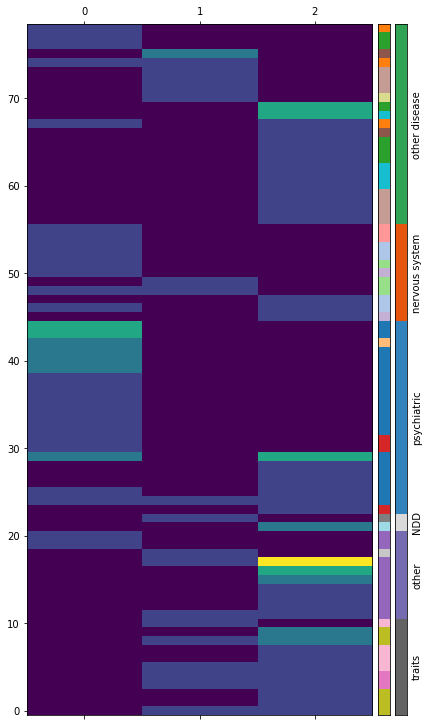

In [38]:
# Build heatmap summarizing data

fig = plt.figure(figsize=(8,16))

# main heat-map showing number of hits
axmatrix = fig.add_axes([0.3, 0.1, 0.6, 0.6])
im = axmatrix.matshow(sortdf[['C1','C2','C3']],vmax=5, 
                      aspect='auto', origin='lower',) #cmap="YlGnBu")

# categorical heatmap showing subtopic membership
ax2 = fig.add_axes([0.91, 0.1, 0.02, 0.6])
dxim = ax2.matshow(sortdf.subtopic_code.values.reshape(-1,1), 
                        aspect='auto', 
                        origin='lower', cmap="tab20")
ax2.set_xticks([]) # remove labels
ax2.set_yticks([])

# categorical heatmap showing topic membership
ax3 = fig.add_axes([0.94, 0.1, 0.02, 0.6])
dxim = ax3.matshow(sortdf.main_code.values.reshape(-1,1), 
                        aspect='auto', 
                        origin='lower', cmap="tab20c")

ax3.set_xticks([]) # Remove labels
ax3.set_yticks([])

# add in new topic labels manually
sortdf.loc[:,'ind'] = range(len(sortdf))
for term in main_order:
    inds = sortdf[sortdf.main==term].ind.values
    mn = inds.mean()
    plt.text(.95,mn,term,rotation=90,va='center')
    
# plt.savefig(os.path.join(figdir,'PheWAS_full.pdf'),bbox_inches='tight')

Okay that kind of give you a picture of the whole dataset, but it's a bit hard to take it all in. Creating an even more compressed version of the results below.

[]

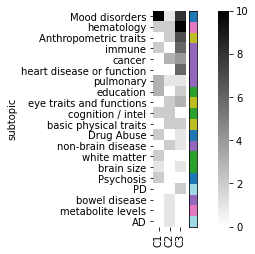

In [39]:
# reorder and regroup dataframe to better consolidate information by subtopic
order = sortdf.groupby('subtopic')[['C1','C2','C3']].sum().sum(1).sort_values(ascending=False
                                                                             ).index
labdf = sortdf.groupby('subtopic')[['main_code','main']].first()

# build main heatmap
fig = plt.figure(figsize=(5,5))
mat = fig.add_axes([0.3, 0.1, 0.6, 0.6])
sns.heatmap(sortdf.groupby('subtopic')[['C1','C2','C3']].sum().loc[order],
            cmap='binary',vmax=10,ax=mat,square=True, cbar_kws={'pad':0.15})

# add categorical heatmap with main topic
ax2 = fig.add_axes([0.73, 0.1, 0.02, 0.6])
dxim = ax2.matshow(labdf.loc[order.tolist()[::-1]].main_code.values.reshape(-1,1), 
                        aspect='auto', 
                        origin='lower', cmap="tab20")
ax2.set_xticks([]) # remove labels
ax2.set_yticks([])

# save
#plt.savefig(os.path.join(figdir,'PheWAS_condensed.pdf'), bbox_inches='tight')

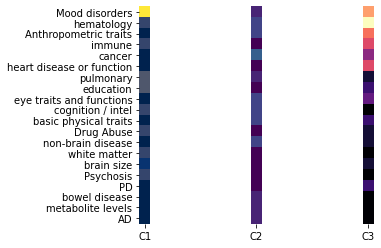

In [40]:
# In case I wish to come back and make this multicolored, leaving this code here....
jnk = sortdf.groupby('subtopic')[['C1','C2','C3']].sum().loc[order]

cm = ['cividis', 'viridis', 'magma',]
f, axs = plt.subplots(1, jnk.columns.size, gridspec_kw={'wspace': 0})
for i, (s, a, c) in enumerate(zip(jnk.columns, axs, cm)):
    sns.heatmap(np.array([jnk[s].values]).T, yticklabels=jnk.index,vmax=10, 
                xticklabels=[s],square=True, ax=a, cmap=c, cbar=False)
    if i>0:
        a.yaxis.set_ticks([])

# Supplemental table

Need to create a supplemental table for the manuscript that gives a tabulated version of information in the Alluvial plot

In [48]:
catch = []
for pth in cdf_pths:
    c = pth.split('_')[-1].split('.')[0]
    cdf = pandas.read_csv(pth)
    cdf = cdf[(cdf.hgnc.isin(good_genes)) & pandas.notnull(cdf.X2)]
    cdf.loc[:,'Component'] = c
    catch.append(cdf)
table = pandas.concat(catch)
table.drop([x for x in table.columns if all(pandas.isnull(table[x]))],axis=1,inplace=True)
table = table.reindex(columns=['Component','hgnc','gene'] + [x for x in table.columns if 'X' in x])
table.columns = ['Component','hgnc_symbol','gene_symbol','SNP'] + ['Pheno%s'%x for x in range(1,7)]
table.index = range(len(table))

In [49]:
table

,Component,hgnc_symbol,gene_symbol,SNP,Pheno1,Pheno2,Pheno3,Pheno4,Pheno5,Pheno6
0,C1,PART1,ENSG00000152931,rs113552169,Educational attainment (years of education),NaN,NaN,NaN,NaN,NaN
1,C1,FREM3,ENSG00000183090,rs115339319,Response to cognitive-behavioural therapy in a...,NaN,NaN,NaN,NaN,NaN
2,C1,SLC17A6,ENSG00000091664,rs11026774,General cognitive ability,NaN,NaN,NaN,NaN,NaN
3,C1,FAM215B,ENSG00000232300,rs112333322,Experiencing mood swings,NaN,NaN,NaN,NaN,NaN
4,C1,FAM215B,ENSG00000232300,rs974295,Household income,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
81,C3,HAPLN4,ENSG00000187664,rs8103992,Pulse pressure,Lymphocyte counts,Lymphocyte counts,Monocyte count,NaN,NaN
82,C3,HAPLN4,ENSG00000187664,rs8108659,Height,NaN,NaN,NaN,NaN,NaN
83,C3,HAPLN4,ENSG00000187664,rs56159542,Attention deficit hyperactivity disorder sympt...,NaN,NaN,NaN,NaN,NaN
84,C3,HAPLN4,ENSG00000187664,rs11879838,Basophil count,Basophil percentage of white cells,NaN,NaN,NaN,NaN


In [50]:
table.to_csv('tables/PheWAS_results.csv')